In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from ltu_ili_testing import EmpiricalUncertaintyModel, SBI_Fitter
from astropy.table import Table
import numpy as np
from unyt import Jy

device = 'cuda:0'

grid_path = '/home/tharvey/work/output/grid_BPASS_DelayedExponential_SFH_0.01_z_12_logN_5.7_Chab_CF00_v1.hdf5'



Device: cuda
Pytorch version: 2.4.1
ROCM HIP version: 6.1.40093-e3dc58bf0


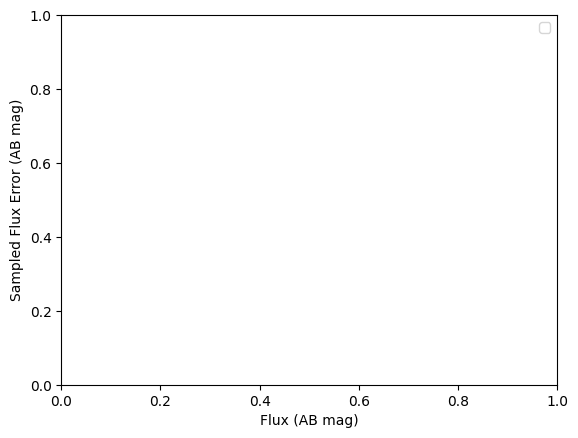

In [79]:
file = '/home/tharvey/Downloads/JADES-Deep-GS_MASTER_Sel-f277W+f356W+f444W_v9_loc_depth_masked_10pc_EAZY_matched_selection_ext_src_UV.fits'
table = Table.read(file)

jades_filters = ['f090W', 'f115W', 'f150W', 'f200W', 'f277W', 'f335M', 'f356W', 'f410M', 'f444W']

empirical_noise_models = {}
data = []
for filter_name in jades_filters:
    fitter_filter_name = f'JWST/NIRCam.{filter_name.upper()}'

    flux = table[f'MAG_APER_{filter_name}_aper_corr'][:, 0]
    flux_err_l = table[f'MAGERR_APER_{filter_name}_l1_loc_depth'][:, 0]
    flux_err_u = table[f'MAGERR_APER_{filter_name}_u1_loc_depth'][:, 0]

    mask = (flux != -99) & (flux_err_l != -99) & (flux_err_u != -99) & (flux_err_l > 0) & (flux_err_u > 0)
    data.append(flux)
    flux = flux[mask]
    flux_err_l = flux_err_l[mask]
    flux_err_u = flux_err_u[mask]

    #noise_model = EmpiricalUncertaintyModel(flux, (flux_err_l + flux_err_u) / 2, 
    #                                        num_bins=100, log_bins=True,
    #                                        min_flux_error=0.001, error_type='observed')
    #empirical_noise_models[fitter_filter_name] = noise_model



# Plot median line for all
flux = np.linspace(23, 40, 1000)
flux = 10**(-0.4 * (flux - 8.90))
colors = plt.cm.viridis(np.linspace(0, 1, len(empirical_noise_models)))
for a, (filter_name, noise_model) in enumerate(empirical_noise_models.items()):
    noisy_flux, sampled_sigma = noise_model.apply_noise_to_flux(flux, true_flux_units=Jy, out_units="AB")
    plt.scatter(noisy_flux, sampled_sigma, label=f'{filter_name}', alpha=0.5, color=colors[a], s=1)
plt.xlabel('Flux (AB mag)')
plt.ylabel('Sampled Flux Error (AB mag)')

plt.legend()

In [1]:
empirical_model_fitter = SBI_Fitter.init_from_hdf5('Pop_II_LogNormal_SFH_5_z_12_logN_5.0_BPASS_Chab_v1_ensemble_redshift_empirical_noise', 
                                grid_path, return_output=False)

empirical_model_fitter.create_feature_array_from_raw_photometry(extra_features=[], 
                                                                normalize_method=None,
                                                                include_errors_in_feature_array=True,
                                                                scatter_fluxes=1,
                                                                empirical_noise_models=empirical_noise_models,
                                                                photometry_to_remove=[filt for filt in empirical_model_fitter.raw_photometry_names if filt not in list(empirical_noise_models.keys())],
);



NameError: name 'SBI_Fitter' is not defined

In [ ]:
empirical_model_fitter.run_single_sbi(
                    n_nets=2,
                    backend='lampe',
                    engine='NPE', 
                    stop_after_epochs=15, 
                    hidden_features=180,
                    learning_rate=0.0004,
                    num_transforms=16,
                    model_type='nsf')

TODO: Take well understood output from e.g. Bagpipes for JADES galaxies, and fit them and compare. 

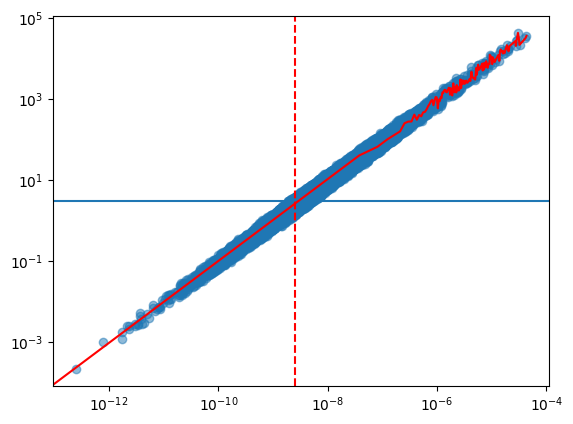

In [61]:
from scipy.interpolate import UnivariateSpline, interp1d
from astropy import units as u
filter_name = 'f090W'

fluxes = table[f'FLUX_APER_{filter_name}_aper_corr_Jy'][:, 0]
errors = table[f'loc_depth_{filter_name}'][:, 0] * u.ABmag
errors = errors.to('Jy').value/5

sorted_indices = np.argsort(fluxes)
fluxes = fluxes[sorted_indices]
errors = errors[sorted_indices]

# remove naninf

mask = np.isfinite(fluxes) & np.isfinite(errors) & (errors > 0)
fluxes = fluxes[mask]
errors = errors[mask]


plt.loglog(fluxes, fluxes/errors, 'o', label=f'{filter_name} Errors', alpha=0.5)
plt.axhline(y=3)

interp = interp1d(fluxes, fluxes/errors)

interp2 = interp1d(fluxes/errors, fluxes)

# plot spline

flux_range = np.linspace(fluxes.min(), fluxes.max(), 1000)
plt.plot(flux_range,interp(flux_range), label=f'{filter_name} Interpolated Errors', color='red')
interp2(3)

plt.axvline(x=interp2(3), color='red', linestyle='--', label=f'{filter_name} 3-sigma Flux Limit')

In [62]:
import numpy as np
from scipy.linalg import inv
from typing import Tuple

def filter_out_of_distribution(
    observed_photometry: np.ndarray,
    simulated_photometry: np.ndarray,
    sigma_threshold: float = 5.0
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Identifies and removes samples from a simulated dataset that are
    out-of-distribution compared to a reference observed dataset.

    The function calculates the Mahalanobis distance for each simulated sample
    to the mean of the observed samples, accounting for the covariance
    between filters. Samples with a distance greater than the specified
    sigma_threshold are considered outliers and are removed.

    Args:
        observed_photometry (np.ndarray): The reference dataset, expected to
                                          have a shape of (N_filters, N_obs_samples).
        simulated_photometry (np.ndarray): The dataset to be filtered, expected
                                           to have a shape of (N_filters, N_sim_samples).
        sigma_threshold (float, optional): The number of standard deviations
                                           (in Mahalanobis distance) to use as the
                                           outlier threshold. Defaults to 5.0.

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - A NumPy array containing the filtered simulated photometry with outliers removed.
              The shape will be (N_filters, N_inliers).
            - A 1D NumPy array containing the indices of the rows (samples) that were
              identified as outliers and removed from the original simulated_photometry.
    """
    if observed_photometry.shape[0] != simulated_photometry.shape[0]:
        raise ValueError("observed_photometry and simulated_photometry must have the same number of filters (rows).")

    # Transpose data so that samples are rows and filters (features) are columns
    # Shape becomes (N_samples, N_filters)
    obs_data = observed_photometry.T
    sim_data = simulated_photometry.T

    # Calculate the mean vector and inverse covariance matrix of the observed data
    try:
        mean_obs = np.mean(obs_data, axis=0)
        cov_obs = np.cov(obs_data, rowvar=False)
        inv_cov_obs = inv(cov_obs)
    except np.linalg.LinAlgError:
        raise ValueError(
            "Could not compute the inverse covariance matrix of the observed_photometry. "
            "This can happen if the data is not full rank (e.g., filters are perfectly correlated)."
        )

    # Calculate the Mahalanobis distance for each simulated sample from the observed distribution
    mahalanobis_distances = np.zeros(sim_data.shape[0])
    for i in range(sim_data.shape[0]):
        delta = sim_data[i] - mean_obs
        # Manual calculation of Mahalanobis distance: sqrt(delta' * inv_cov * delta)
        mahalanobis_distances[i] = np.sqrt(delta @ inv_cov_obs @ delta.T)

    # Identify the indices of outliers
    outlier_indices = np.where(mahalanobis_distances > sigma_threshold)[0]
    inlier_indices = np.where(mahalanobis_distances <= sigma_threshold)[0]

    # Filter the original simulated_photometry array using the inlier indices
    # We filter the original array with shape (N_filters, N_samples)
    filtered_sim_photometry = simulated_photometry[:, inlier_indices]

    print(f"Original number of simulated samples: {simulated_photometry.shape[1]}")
    print(f"Number of outliers removed ({sigma_threshold}-sigma): {len(outlier_indices)}")
    print(f"Number of samples remaining: {filtered_sim_photometry.shape[1]}")

    return filtered_sim_photometry, outlier_indices

# --- Example Usage ---
if __name__ == '__main__':
    # 1. Define the parameters for our synthetic data
    N_FILTERS = 10
    N_OBS_SAMPLES = 10000
    N_SIM_SAMPLES = 2000

    # 2. Generate the 'observed_photometry' data
    # Let's create a correlated multivariate normal distribution
    # Create a random covariance matrix that is positive semi-definite
    np.random.seed(42)
    temp_matrix = np.random.rand(N_FILTERS, N_FILTERS)
    covariance_matrix = np.dot(temp_matrix, temp_matrix.T) + np.eye(N_FILTERS) * 0.1
    mean_vector = np.random.rand(N_FILTERS) * 10

    observed_photometry = np.random.multivariate_normal(
        mean=mean_vector,
        cov=covariance_matrix,
        size=N_OBS_SAMPLES
    ).T  # Transpose to get shape (N_filters, N_samples)

    print(f"Shape of observed_photometry: {observed_photometry.shape}")

    # 3. Generate the 'simulated_photometry' data
    # This will be from the same distribution, but we'll add some outliers
    simulated_photometry = np.random.multivariate_normal(
        mean=mean_vector,
        cov=covariance_matrix,
        size=N_SIM_SAMPLES
    ).T

    # Add 50 clear outliers by shifting them by a large amount
    num_outliers_to_add = 50
    outlier_indices_added = np.random.choice(N_SIM_SAMPLES, num_outliers_to_add, replace=False)
    simulated_photometry[:, outlier_indices_added] += np.random.randn(N_FILTERS, num_outliers_to_add) * 5

    print(f"Shape of simulated_photometry before filtering: {simulated_photometry.shape}")
    print("-" * 30)

    # 4. Run the filtering function
    SIGMA_CUT = 5.0
    filtered_photometry, removed_indices = filter_out_of_distribution(
        observed_photometry=observed_photometry,
        simulated_photometry=simulated_photometry,
        sigma_threshold=SIGMA_CUT
    )

    print("-" * 30)
    print(f"Shape of simulated_photometry after filtering: {filtered_photometry.shape}")
    print(f"Indices of removed outliers (first 20): {removed_indices[:20]}")

    # Verify that the manually added outliers were caught
    caught_outliers = np.intersect1d(removed_indices, outlier_indices_added)
    print(f"Number of known outliers correctly identified: {len(caught_outliers)} out of {num_outliers_to_add}")
    

Shape of observed_photometry: (10, 10000)
Shape of simulated_photometry before filtering: (10, 2000)
------------------------------
Original number of simulated samples: 2000
Number of outliers removed (5.0-sigma): 64
Number of samples remaining: 1936
------------------------------
Shape of simulated_photometry after filtering: (10, 1936)
Indices of removed outliers (first 20): [103 157 187 207 215 242 244 261 267 322 360 366 376 406 409 571 573 620
 643 692]
Number of known outliers correctly identified: 50 out of 50


In [83]:
simulated_photometry = empirical_model_fitter.feature_array[:, :9]

simulated_photometry.shape

(500000, 9)

In [92]:
observed_photometry = np.array(data).T

# drop any row with a -99

mask = np.all(observed_photometry != 99, axis=1)
observed_photometry = observed_photometry[mask]



array([[21.355497, 20.875423, 20.62986 , ..., 21.11414 , 21.211205,
        21.286192],
       [22.140362, 21.78344 , 21.383684, ..., 21.288572, 21.44429 ,
        21.411959],
       [23.719885, 23.627226, 23.583918, ..., 24.247158, 24.379063,
        24.49247 ],
       ...,
       [30.012718, 29.352957, 28.79283 , ..., 28.50831 , 28.627861,
        28.720343],
       [24.457455, 23.773369, 23.21094 , ..., 22.060541, 22.1548  ,
        22.251919],
       [30.645512, 31.044193, 29.974436, ..., 30.283998, 29.959839,
        31.20093 ]], shape=(31586, 9), dtype=float32)

In [100]:
# DO this with real data

simulated_photometry = empirical_model_fitter.feature_array[:, :9]

filtered_photometry, removed_indices = filter_out_of_distribution(
    observed_photometry=observed_photometry.T,
    simulated_photometry=simulated_photometry.T,
    sigma_threshold=8
)

Original number of simulated samples: 500000
Number of outliers removed (8-sigma): 342865
Number of samples remaining: 157135


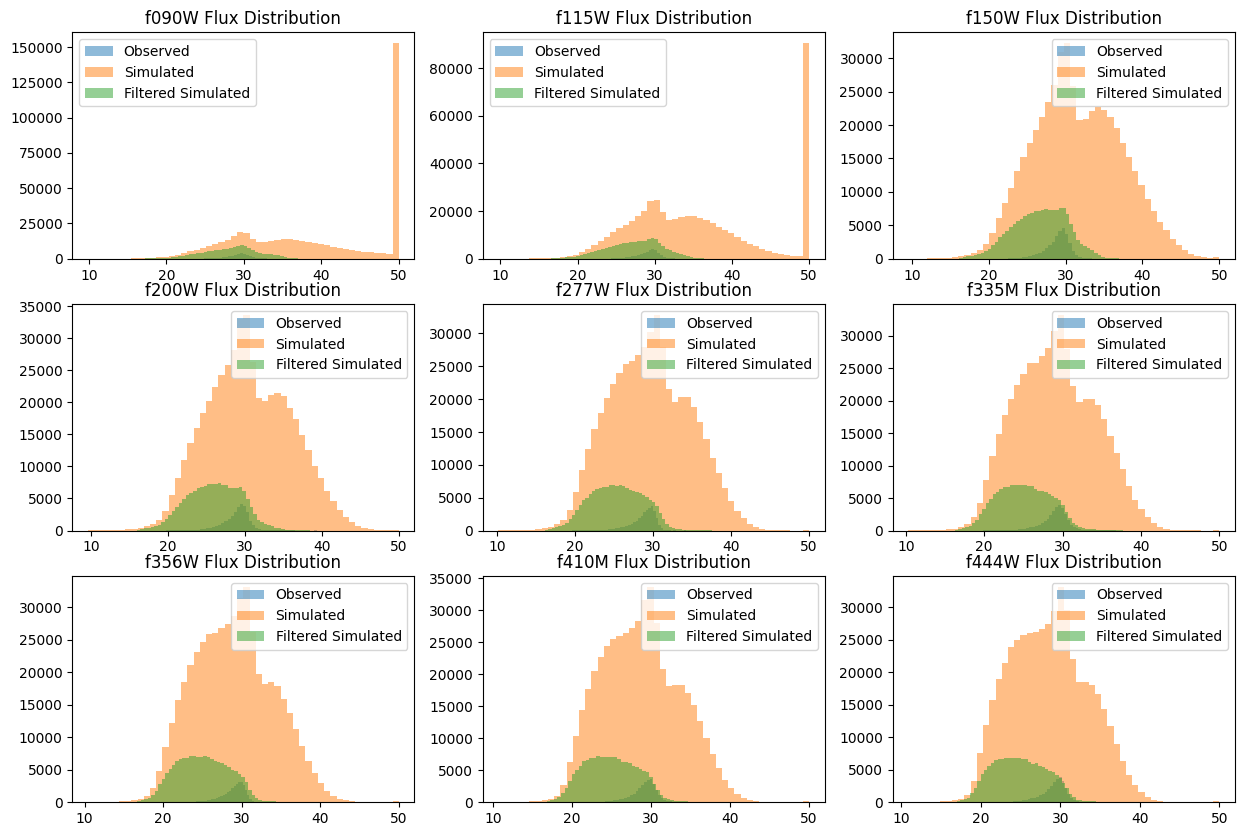

In [101]:
# compare distribution of fluxes before and after filtering

fig, axs = plt.subplots(3, np.ceil(len(observed_photometry[0]) / 3).astype(int), figsize=(15, 10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < len(observed_photometry[0]):
        ax.hist(observed_photometry[:, i], bins=50, alpha=0.5, label='Observed')
        ax.hist(simulated_photometry[:, i], bins=50, alpha=0.5, label='Simulated')
        ax.hist(filtered_photometry[i], bins=50, alpha=0.5, label='Filtered Simulated')
        ax.set_title(f'{jades_filters[i]} Flux Distribution')
        ax.legend()
    else:
        ax.axis('off')